In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("..")

In [6]:
from src.vols.expou import ExpOU
from src.losses.rbfmmdloss import RBFMMDLoss
from src.networks.rnn import RNNNetwork
from src.utils import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
set_plot_params()

In [15]:
N_paths = 100000
total_timesteps = 60*60*7.5 #1 second data
n_timesteps = 10 #train at 1 min interval

heston_model = ExpOU(theta=1.0, beta=0.2, rho=0.0)
spots, vols = heston_model.generate(N_paths, total_timesteps, n_timesteps, reshape_for_rnn=True)

First train a model using a method of moments. We try to match the first $k$ moments of the distribution generated by 
$$
Z_F = \frac{X_1 - X_0}{\sqrt{F(X_0,X_{1/n},X_{2/n},\ldots,X_{(n-1)/n},X_1)}}
$$
to those of the standard normal. We set $k=4$ and train using the $L1$ norm. We use a simple feedforward neural network, and train for 10 epochs.

In [35]:
rbfmmd_loss = RBFMMDLoss(length_scale=1.0)
rbfmmd_model = RNNNetwork(n_layers=4, h_dims=128, recurrent_type='lstm', loss=rbfmmd_loss)

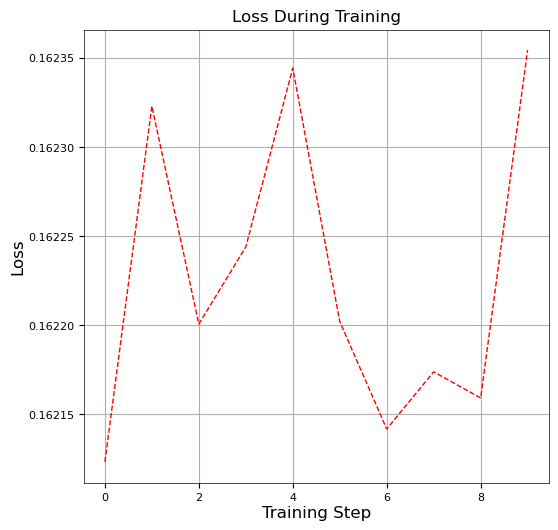

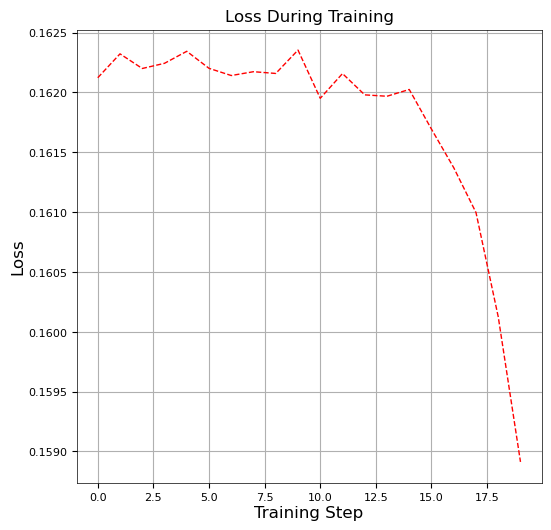

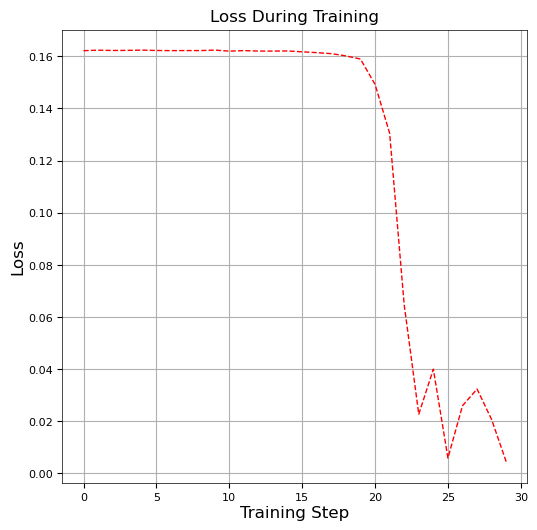

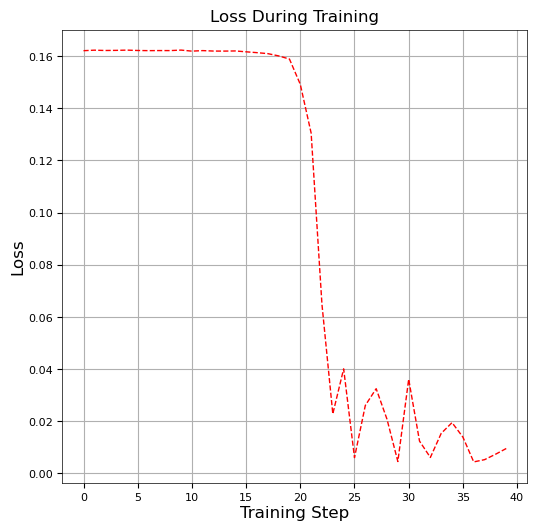

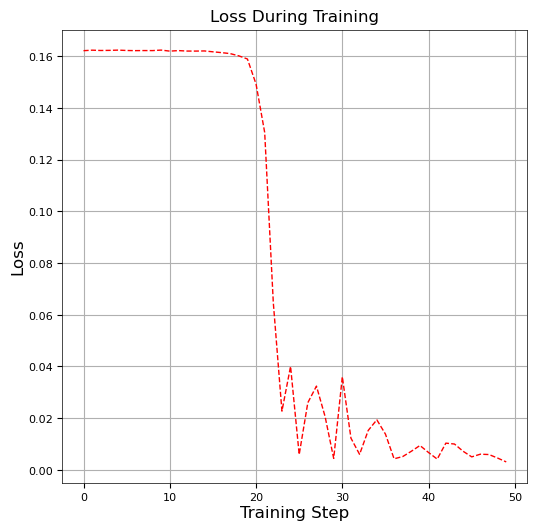

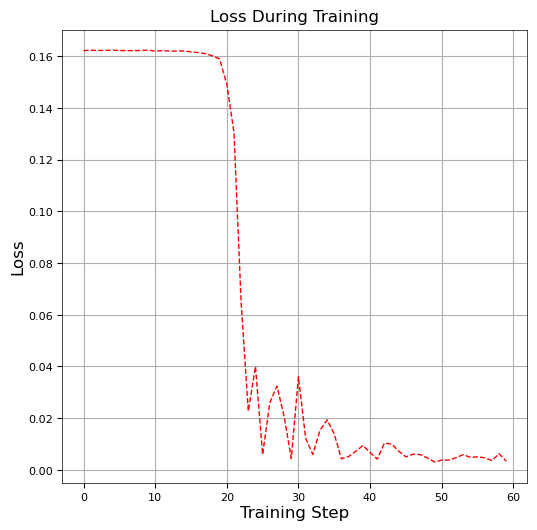

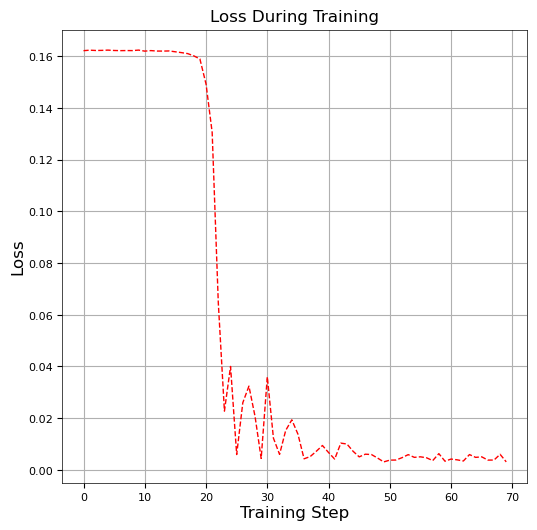

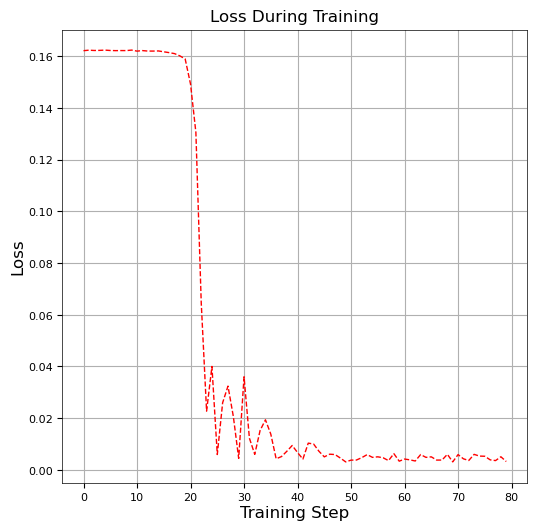

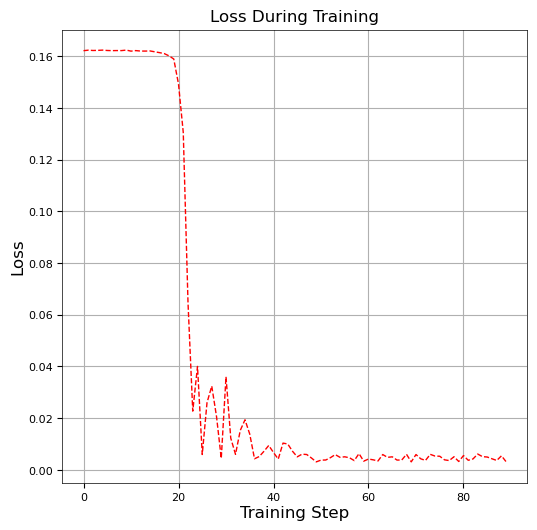

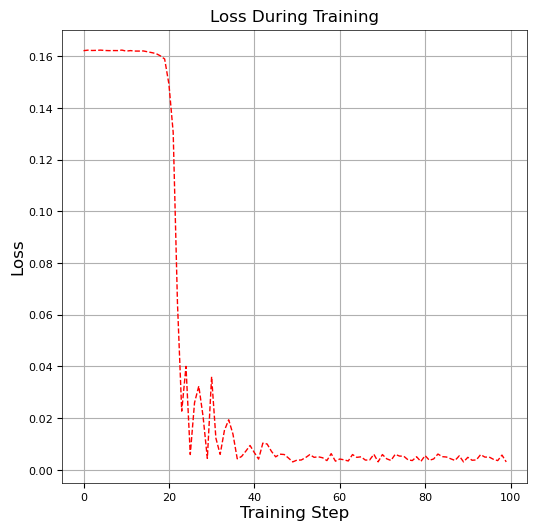

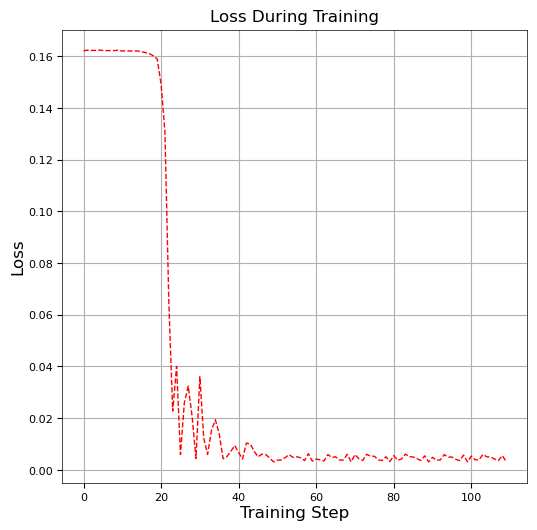

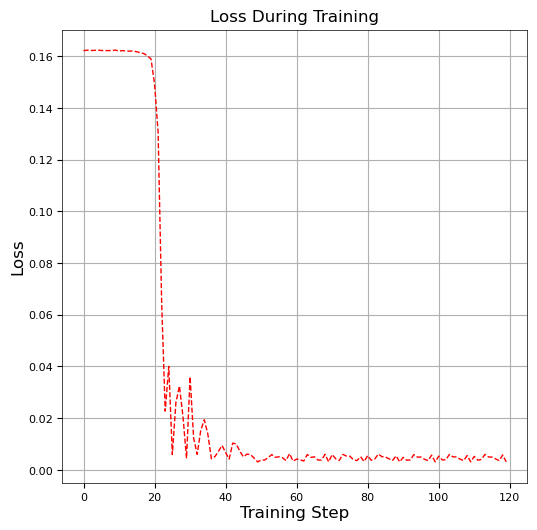

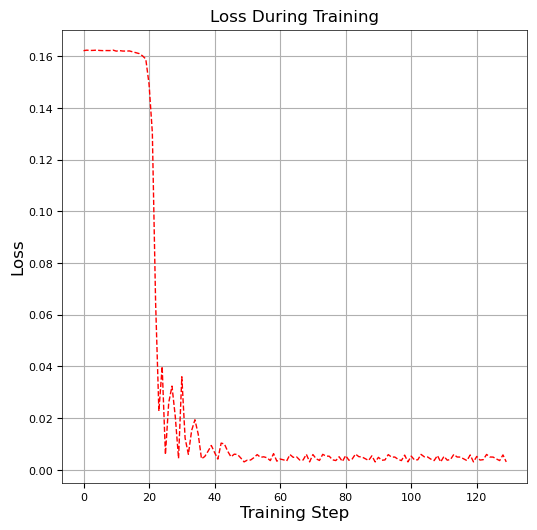

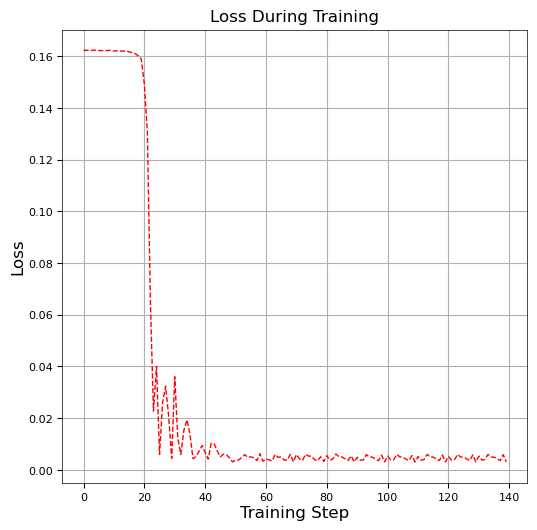

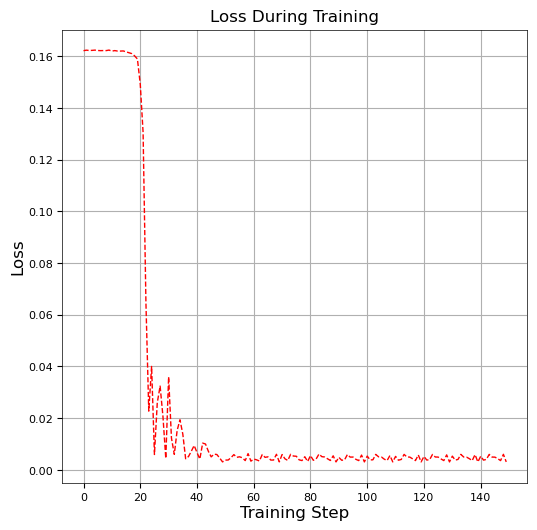

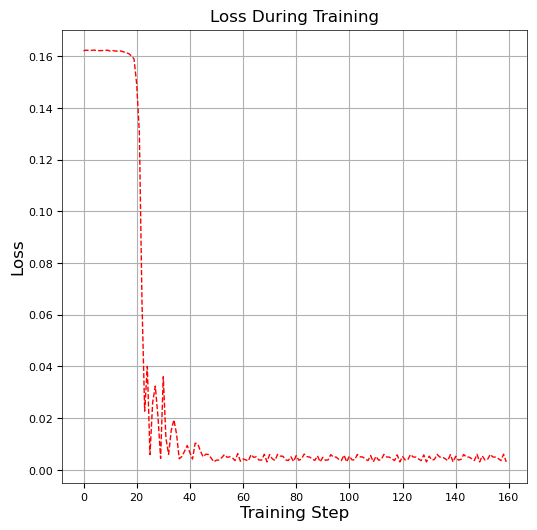

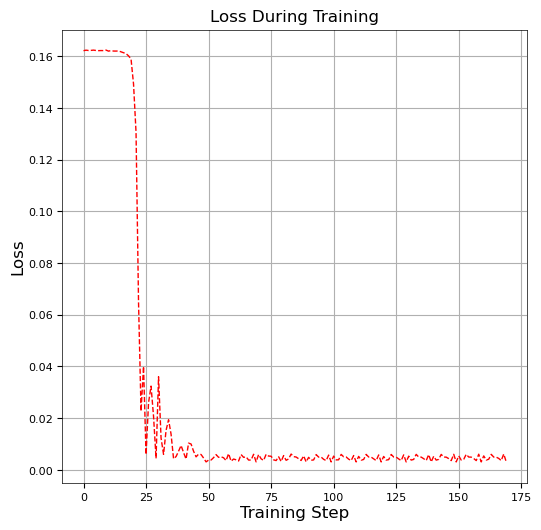

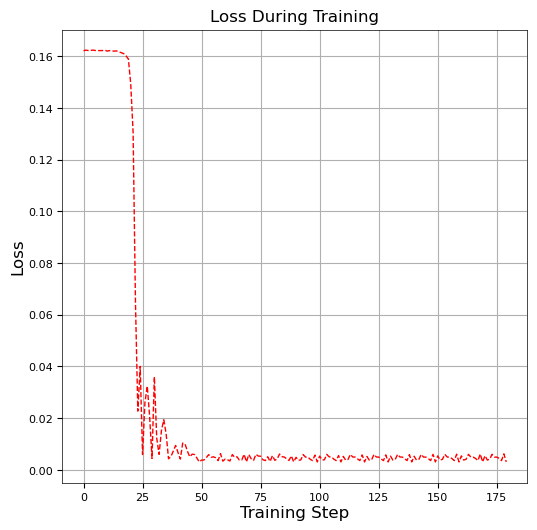

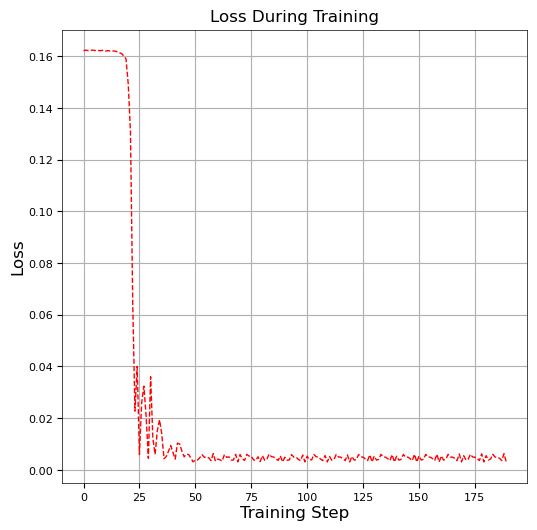

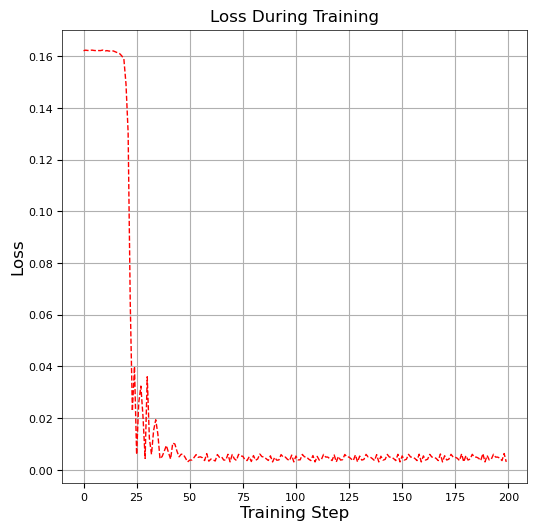

In [37]:
history = rbfmmd_model.train(spots, num_epochs=20, batch_size=1024, lr=0.001)

In [18]:
spots, vols = heston_model.generate(10000, total_timesteps, n_timesteps, reshape_for_rnn=True)
iv = rbfmmd_model.predict_iv(spots)

In [19]:
plt.hist(np.sqrt(iv) / np.sqrt(np.squeeze(true_ivs)))

NameError: name 'true_ivs' is not defined

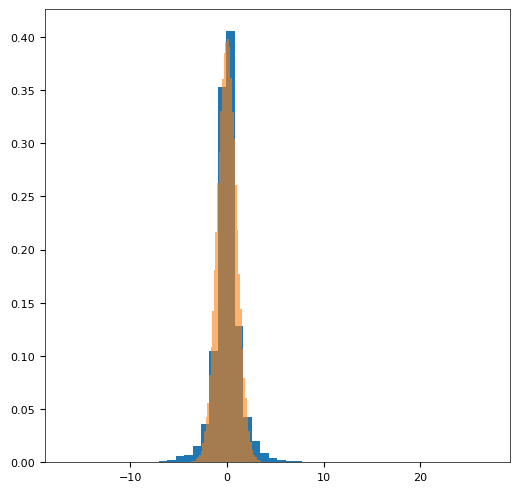

In [20]:
plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(iv), bins=50, density=True)
#plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.squeeze(true_ivs)), bins=50, density=True)
#plt.hist((spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.mean(true_ivs)), bins=50, alpha=0.6, density=True)


plt.hist(np.random.normal(size=100000), bins=50, alpha=0.6, density=True)
plt.show()

In [188]:
z = (spots[:,-1,0] - spots[:,0,0])/np.sqrt(np.squeeze(true_ivs))

In [190]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], np.squeeze(true_ivs))

<tf.Tensor: shape=(), dtype=float64, numpy=0.0003705099211863683>

In [191]:
RBFMMDLoss()(spots[:,-1,0] - spots[:,0,0], iv)

<tf.Tensor: shape=(), dtype=float64, numpy=-1.6726540690958913e-05>

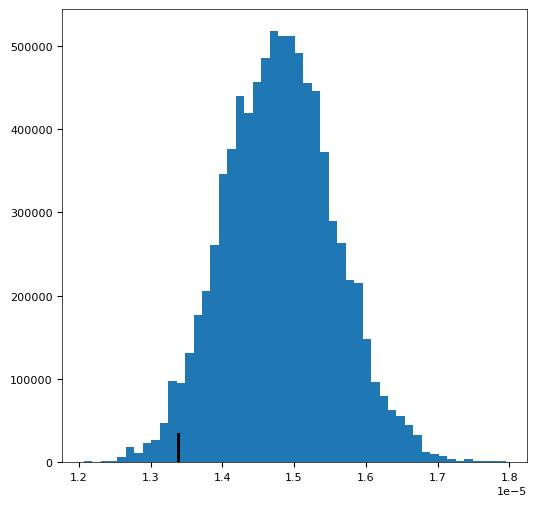

In [171]:
plt.hist(true_ivs, bins=50, density=True)
plt.vlines(iv, ymin=0, ymax=35000.0)
plt.show()

In [181]:
np.mean(true_ivs)

1.4802211489946724e-05